In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

PATH = '/content/gdrive/MyDrive/Spect2WAV/sound.wav' 

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import os

3.3750625 min


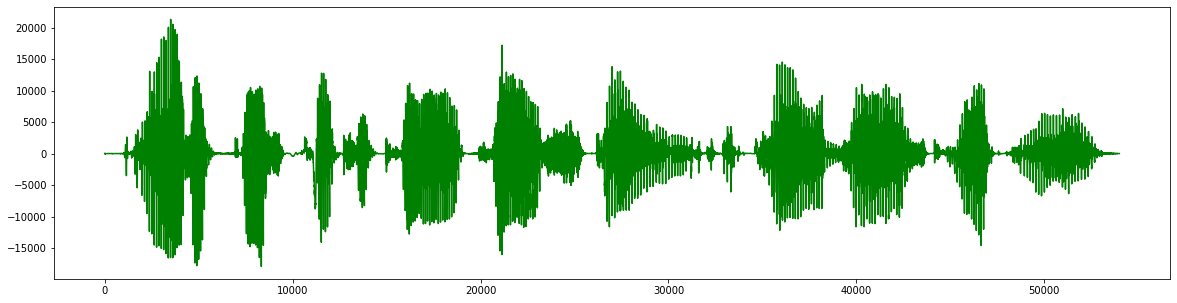

In [ ]:
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt

rate, audData=scipy.io.wavfile.read( PATH)
print( audData.shape[0] / rate , 'min')
channel1 = audData[:] 

plt.figure(figsize = (20, 5))
plt.plot(audData, 'g')
plt.show()

In [ ]:
signal_fragment = channel1[16000:32000]   # channel1[0:16000]

In [ ]:
import numpy as np
import math
from PIL import Image
import time

In [ ]:
FFT_LENGTH = 1024//2
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
magnitudeMin = float("inf")
magnitudeMax = float("-inf")
phaseMin = float("inf")
phaseMax = float("-inf")

In [ ]:
def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def generateLinearScale(magnitudePixels, phasePixels, 
                        magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    height = magnitudePixels.shape[0]
    width = magnitudePixels.shape[1]
    magnitudeRange = magnitudeMax - magnitudeMin
    phaseRange = phaseMax - phaseMin
    rgbArray = np.zeros((height, width, 3), 'uint8')
    
    for w in range(width):
        for h in range(height):
            magnitudePixels[h,w] = (magnitudePixels[h,w] - magnitudeMin) / (magnitudeRange) * 255 * 2
            magnitudePixels[h,w] = amplifyMagnitudeByLog(magnitudePixels[h,w])
            phasePixels[h,w] = (phasePixels[h,w] - phaseMin) / (phaseRange) * 255
            red = 255 if magnitudePixels[h,w] > 255 else magnitudePixels[h,w]
            green = (magnitudePixels[h,w] - 255) if magnitudePixels[h,w] > 255 else 0
            blue = phasePixels[h,w]
            rgbArray[h,w,0] = int(red)
            rgbArray[h,w,1] = int(green)
            rgbArray[h,w,2] = int(blue)
    return rgbArray

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, 
                       phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

In [ ]:
def generateSpectrogramForWave(signal):
    start_time = time.time()
    global magnitudeMin
    global magnitudeMax
    global phaseMin
    global phaseMax
    buffer = np.zeros(int(signal.size + WINDOW_STEP - (signal.size % WINDOW_STEP)))
    buffer[0:len(signal)] = signal
    height = int(FFT_LENGTH / 2 + 1)
    width = int(len(buffer) / (WINDOW_STEP) - 1)
    magnitudePixels = np.zeros((height, width))
    phasePixels = np.zeros((height, width))

    for w in range(width):
        buff = np.zeros(FFT_LENGTH)
        stepBuff = buffer[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH]
        # apply hanning window
        stepBuff = stepBuff * np.hanning(WINDOW_LENGTH)
        buff[0:len(stepBuff)] = stepBuff
        #buff now contains windowed signal with step length and padded with zeroes to the end
        fft = np.fft.rfft(buff)
        for h in range(len(fft)):
            #print(buff.shape)
            #return
            magnitude = math.sqrt(fft[h].real**2 + fft[h].imag**2)
            if magnitude > magnitudeMax:
                magnitudeMax = magnitude 
            if magnitude < magnitudeMin:
                magnitudeMin = magnitude


            phase = math.atan2(fft[h].imag, fft[h].real)
            if phase > phaseMax:
                phaseMax = phase
            if phase < phaseMin:
                phaseMin = phase
            magnitudePixels[height-h-1,w] = magnitude
            phasePixels[height-h-1,w] = phase
    rgbArray = generateLinearScale(magnitudePixels, phasePixels,
                                  magnitudeMin, magnitudeMax, phaseMin, phaseMax)
    elapsed_time = time.time() - start_time
    print('%.2f' % elapsed_time, 's', sep='')
    img = Image.fromarray(rgbArray, 'RGB')
    return img

img = generateSpectrogramForWave(signal_fragment)
img.save("/content/gdrive/MyDrive/Spect2WAV/spectrogram.png","PNG")

# generateSpectrogramForWave(signal_fragment)

0.14s


In [ ]:
pix = np.array( img)
np.shape(pix)

(257, 62, 3)

In [ ]:
im = np.array( img)
np.shape(im)

(257, 62, 3)

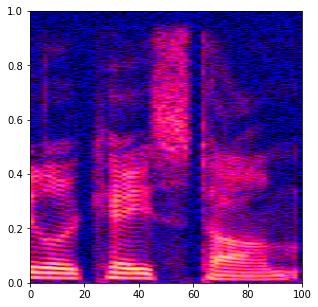

In [ ]:
plt.figure(figsize = (5, 5))
plt.imshow(img, extent=[0,100,0,1], aspect=100)

In [ ]:
def recoverSignalFromSpectrogram(filePath):
# def Spectrogram2Wav(filePath, magnitudeMin=0.1, magnitudeMax=800000, phaseMin = -3.14159, phaseMax = 3.14159 ):
    img = Image.open(filePath)
    data = np.array( img, dtype='uint8' )
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
    
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    scipy.io.wavfile.write("/content/gdrive/MyDrive/Spect2WAV/recovered.wav", rate, recovered)
    
recoverSignalFromSpectrogram("/content/gdrive/MyDrive/Spect2WAV/spectrogram.png")

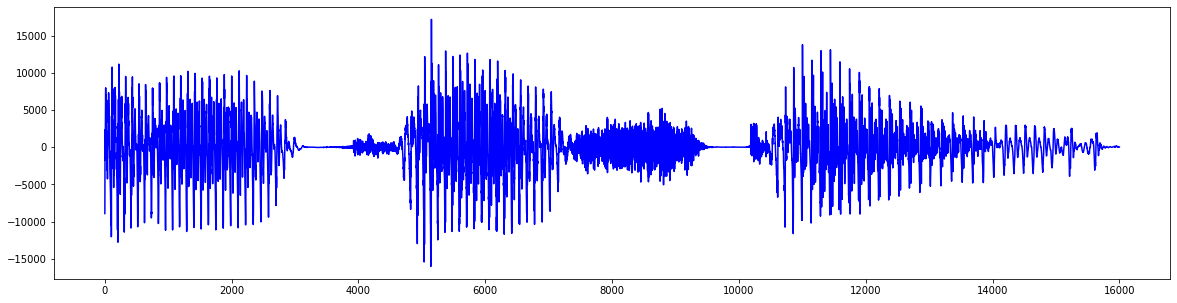

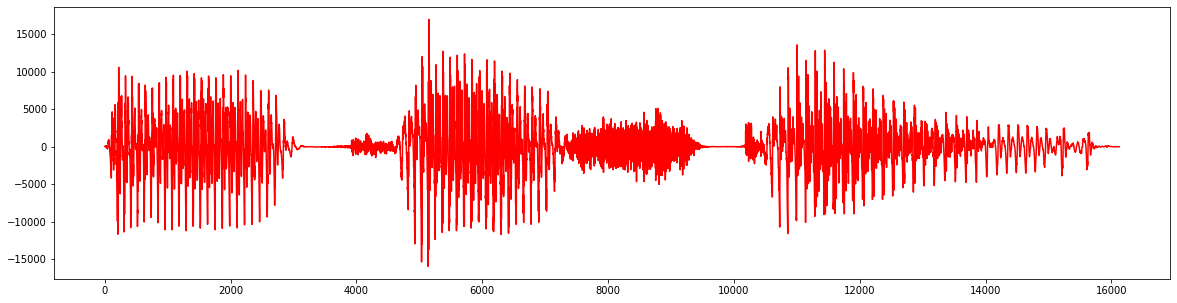

In [ ]:
sr, sig = scipy.io.wavfile.read( "/content/gdrive/MyDrive/Spect2WAV/recovered.wav")

plt.figure(figsize = (20, 5))
plt.plot(audData[16000:32000], 'b')
plt.show()
plt.figure(figsize = (20, 5))
plt.plot(sig, 'r')
plt.show()

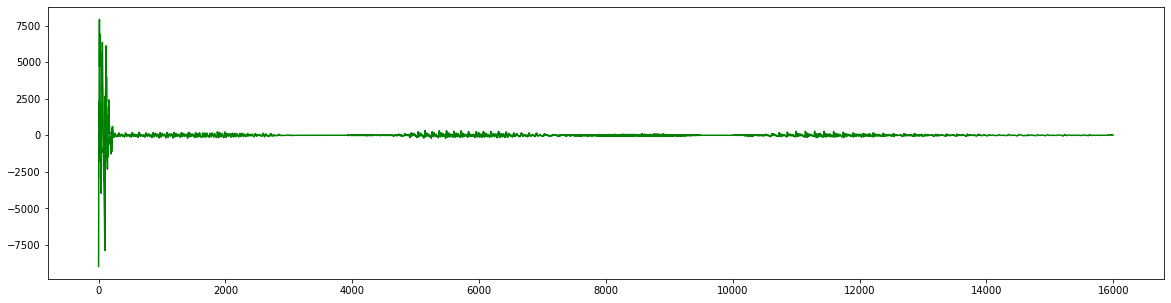

In [ ]:
# corr = np.correlate( audData[16000:32000], sig[0:16000], "full")
s1 = audData[16000:32000]
s2 = sig[0:16000]
diff = []
for i in range(16000):
    diff.append(s1[i]-s2[i])

plt.figure(figsize = (20, 5))
plt.plot( diff, 'g')
plt.show()